In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Load data

In [2]:
train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')

# lets combine train and test into 1 dataframe and drop id column
df = train.drop('Survived', axis = 1).append(test, ignore_index=True).drop(['PassengerId'], axis = 1)

y = train['Survived']
x_id = test['PassengerId']

df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


survival - Survival (0 = No, 1 = Yes)

pclass - Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)

sex - Sex

Age - Age in years

sibsp - # of siblings / spouses aboard the Titanic

parch - # of parents / children aboard the Titanic

ticket - Ticket number

fare - Passenger fare

cabin- Cabin number

embarked - Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

# Feature engineering

In [3]:
#extract Deck? letter from Cabin
df['Deck'] = df['Cabin'].str[0]
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,NaN
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,NaN
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,NaN


In [4]:
#extract titles from Name
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# manual fix of few names
df['Title'].replace(['Mme', 'Countess'], 'Mrs', inplace = True)
df['Title'].replace(['Ms', 'Mlle', 'Dona', 'Lady'], 'Miss', inplace = True)
df['Title'].replace(['Major', 'Jonkheer', 'Capt', 'Don', 'Sir', 'Rev', 'Col'], 'Mr', inplace = True)
df['Title'].value_counts()

Mr        775
Miss      266
Mrs       199
Master     61
Dr          8
Name: Title, dtype: int64

In [5]:
# fare price per ticket -> price per person
df['Fare_adjust'] = df['Fare']
# add group size (not all groups are made of relatives)
df['Group_size'] = df['SibSp'] + df['Parch'] + 1
ticket_duplicates = df[df.duplicated('Ticket', keep = False)].sort_values('Ticket').groupby('Ticket').count()[['Pclass']].rename(columns = {'Pclass':'Count'})

for ticket in ticket_duplicates.index:
    idx = df[df['Ticket'] == ticket].index
    df.loc[idx, 'Fare_adjust'] /= ticket_duplicates.loc[ticket].values
    df.loc[idx, 'Group_size'] = ticket_duplicates.loc[ticket][0]
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,Title,Fare_adjust,Group_size
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,NaN,Mr,7.25000,2
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,Mrs,35.64165,2
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,NaN,Miss,7.92500,1
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C,Mrs,26.55000,2
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,NaN,Mr,8.05000,1


In [6]:
# drop columns
drop_cols = ['Name', 'Cabin', 'Fare', 'Ticket']
#drop_cols = ['Name', 'Cabin', 'Fare']
df.drop(drop_cols, axis =1 , inplace = True)

# Categorical encoding and filling missing values

In [7]:
# it's time to encode categorical features 
encoder = OrdinalEncoder()

df_enc = df.copy()

for cat in df_enc.select_dtypes(include=['object']).columns:
    # encode only not missing values
    cat_mask = df_enc[cat].notna()
    df_enc.loc[cat_mask, cat] = encoder.fit_transform(df_enc[cat_mask][[cat]])
df_enc.head()

,Pclass,Sex,Age,SibSp,Parch,Embarked,Deck,Title,Fare_adjust,Group_size
0,3,1.0,22.0,1,0,2.0,NaN,3.0,7.25000,2
1,1,0.0,38.0,1,0,0.0,2.0,4.0,35.64165,2
2,3,0.0,26.0,0,0,2.0,NaN,2.0,7.92500,1
3,1,0.0,35.0,1,0,2.0,2.0,4.0,26.55000,2
4,3,1.0,35.0,0,0,2.0,NaN,3.0,8.05000,1


In [8]:
# filling na with nearest neighbor imputer (scale -> impute -> scale back)
scaler = MinMaxScaler()
imputer = KNNImputer(n_neighbors=1) # lets go with 1 nearest neigbor (since it can be spose or roommate which is more relevant)

df_enc_imp = pd.DataFrame(scaler.fit_transform(df_enc), columns = df.columns)
df_enc_imp = pd.DataFrame(imputer.fit_transform(df_enc_imp),columns = df.columns)
df_enc_imp = pd.DataFrame(scaler.inverse_transform(df_enc_imp), columns = df.columns)

categories = []
# try smaller category list first
#categories = ['Pclass', 'Embarked', 'Title']

# bigger
#categories = ['Pclass', 'Embarked', 'Title', 'Sex', 'SibSp', 'Parch' , 'Deck', 'Group_size']

# continuous as categorical?
treat_continuous_as_cat = False

if treat_continuous_as_cat:
    continuous = ['Age', 'Fare_adjust']
    categories += continuous
    for cat in continuous:
        df_enc_imp[cat] = pd.cut(df_enc_imp[cat], bins=8, labels=False)

df_enc_imp = df_enc_imp.round().astype(int)

# marking columns as category is enought for lightgbm and it will do one-hot automatically 
df_enc_imp[categories] = df_enc_imp[categories].astype('category') 
# or manualy for other estimators
df_enc_imp_dum = pd.get_dummies(df_enc_imp, columns = categories, drop_first = True)

df_enc_imp_dum.drop(['SibSp', 'Parch'], axis = 1, inplace = True)

df_enc_imp_dum.head()

,Pclass,Sex,Age,Embarked,Deck,Title,Fare_adjust,Group_size
0,3,1,22,2,5,3,7,2
1,1,0,38,0,2,4,36,2
2,3,0,26,2,6,2,8,1
3,1,0,35,2,2,4,27,2
4,3,1,35,2,4,3,8,1


# Exploratory analysis

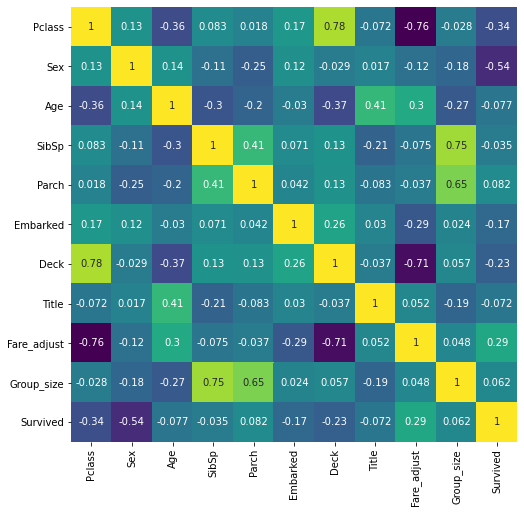

In [9]:
# Plot correlation matrix
df_train = pd.concat([df_enc_imp[:len(y)],y], axis = 1).astype(int)

plt.figure(figsize=(8,8))
sns.heatmap(df_train.corr(), annot=True, cbar=False, cmap = 'viridis')
plt.show()

In [10]:
def plot_group(df, col):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
    
    (df[df['Sex'] == 1].groupby(by = [col, 'Survived']).count()['Sex']/df[df['Sex'] == 1].groupby(by = [col]).count()['Sex']).unstack().plot.bar(ax=ax1)
    ax1.set_title('Male')
    
    (df[df['Sex'] == 0].groupby(by = [col, 'Survived']).count()['Sex']/df[df['Sex'] == 0].groupby(by = [col]).count()['Sex']).unstack().plot.bar(ax=ax2)
    ax2.set_title('Female')
    plt.show()

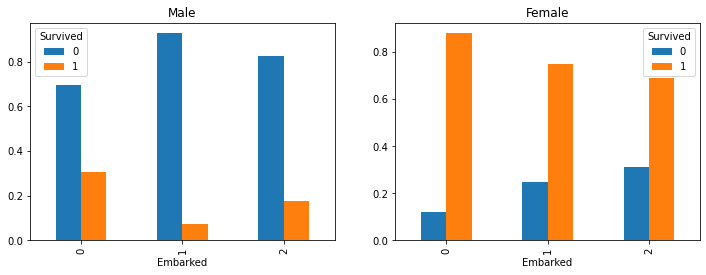

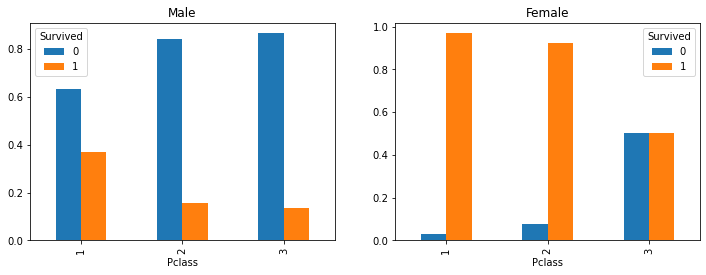

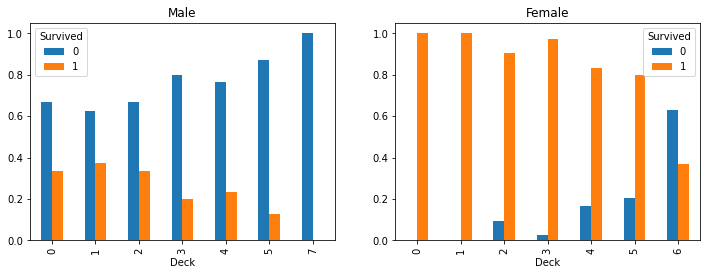

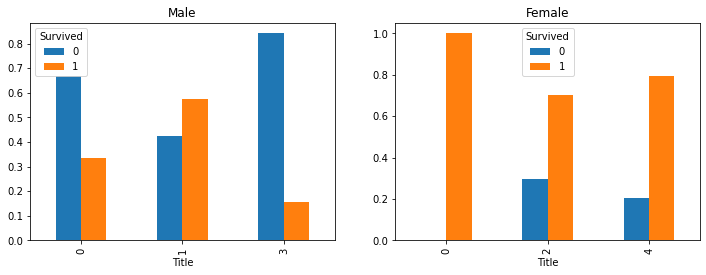

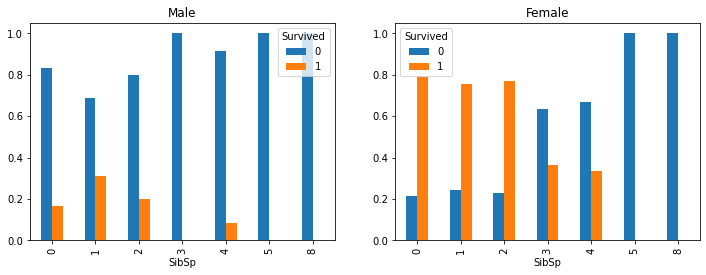

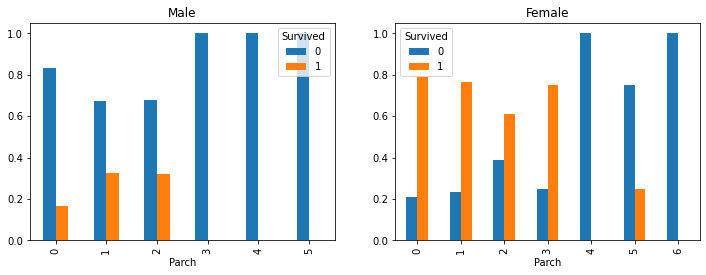

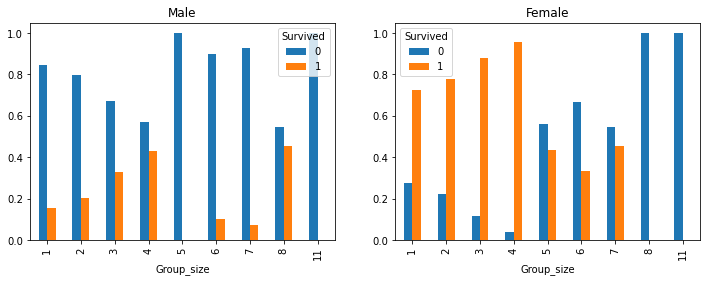

In [11]:
plot_cols = ['Embarked', 'Pclass', 'Deck', 'Title', 'SibSp', 'Parch', 'Group_size']
for col in plot_cols:
    plot_group(df_train, col)

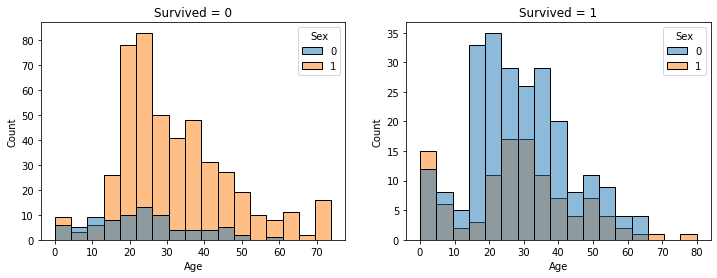

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(df_train[df_train['Survived']==0], x='Age', hue='Sex', ax = ax1)
ax1.set_title('Survived = 0')
sns.histplot(df_train[df_train['Survived']==1], x='Age', hue='Sex', ax = ax2)
ax2.set_title('Survived = 1')
plt.show()

# Machine learning part

In [13]:
# Split data to train and test

train_X = df_enc_imp_dum[:len(y)] # or use dummy df_enc_imp_dum
train_y = y
test_X  = df_enc_imp_dum[len(y):]

model_train_X, model_test_X, model_train_y, model_test_y = train_test_split(
    train_X, train_y, test_size = 0.2, random_state = 2)

In [255]:
# print model evaluation metrics
def model_evaluation(model, model_train_X, model_train_y, model_test_X, model_test_y):
    
    cv_score = cross_val_score(model, model_train_X, model_train_y)
    print('CV-score on train: {:0.3f} with std: {:0.3f}'.format(cv_score.mean(),cv_score.std()))
    print('CV-scores: ', cv_score.round(3))
    
    model.fit(model_train_X, model_train_y)
    model_predict_train_y = model.predict(model_train_X)
    model_predict_test_y = model.predict(model_test_X)

    print('Score on train: {:0.3f} on test: {:0.3f}'.format(model.score(model_train_X,model_train_y), 
                                                            model.score(model_test_X, model_test_y)))
    print('RMSE on train:  {:0.3f} on test: {:0.3f}'.format(mean_squared_error(model_predict_train_y,model_train_y, squared=False), 
                                                            mean_squared_error(model_predict_test_y, model_test_y, squared=False)))
    print('MAE on train:   {:0.3f} on test: {:0.3f}'.format(mean_absolute_error(model_predict_train_y,model_train_y), 
                                                            mean_absolute_error(model_predict_test_y, model_test_y)))
# plot model grid shearch fitting results  
def plot_cv(grid_search):
    results = grid_search.cv_results_
    best_score = grid_search.best_score_
    best_param = grid_search.best_params_
    best_idx = np.nanargmax(results['mean_test_score'])
    max_fits = results['mean_train_score'].shape[0]
    plt.figure(figsize=(18,8))
    plt.plot(range(max_fits),results['mean_train_score'], label = 'Train score')
    plt.fill_between(range(max_fits),
                     results['mean_train_score'] - results['std_train_score'], 
                     results['mean_train_score'] + results['std_train_score'], alpha=0.2)
    plt.plot(range(max_fits),results['mean_test_score'], label = 'Test score')
    plt.fill_between(range(max_fits),
                     results['mean_test_score'] - results['std_test_score'], 
                     results['mean_test_score'] + results['std_test_score'], alpha=0.2)
    plt.plot([best_idx], [best_score], marker='x', ms=20, 
             label = 'Best score: {:0.03f}\nBest param: {}'.format(best_score, best_param))
    if max_fits < 2000:
        plt.xlim((0, results['mean_test_score'].shape[0]))
    else:
        plt.xlim((best_idx-500, best_idx+500))
    plt.title('Accuracy vs GridSearchCV fit')
    plt.legend()
    plt.show()

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   47.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed: 10.7min finished


{'max_depth': 35, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 12, 'n_estimators': 80}
CV-score on train: 0.844 with std: 0.017
CV-scores:  [0.846 0.874 0.845 0.831 0.824]
Score on train: 0.876 on test: 0.810
RMSE on train:  0.352 on test: 0.436
MAE on train:   0.124 on test: 0.190


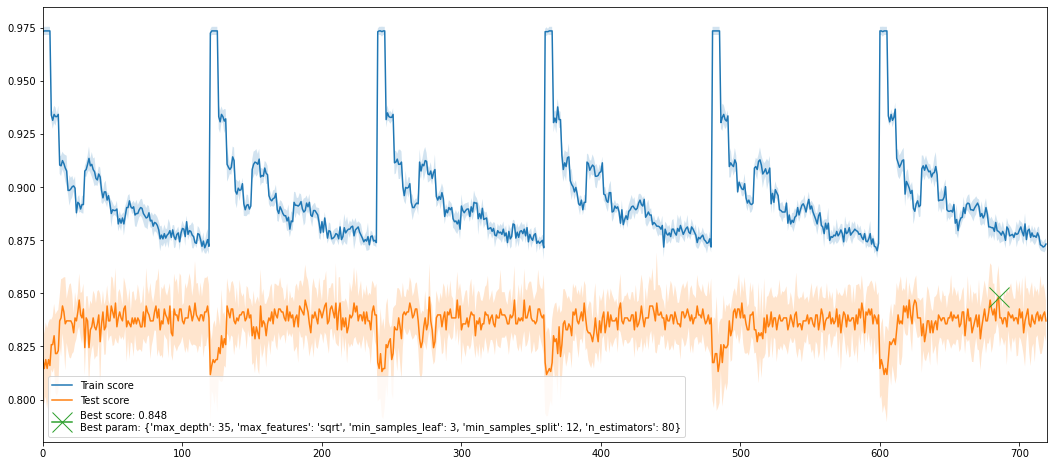

In [204]:
# Forest model hyperparameter tuning with GridSearchCV
model = RandomForestClassifier()

parameters = {
    'n_estimators': np.arange(70, 130, 10),
    'max_depth': [25, 30, 35],
    'min_samples_split' : [2, 5, 8, 10, 12, 15],
    'min_samples_leaf' : [1, 2, 3, 4],
    'max_features': ['auto', 'sqrt']
}

grid_search = GridSearchCV(model, parameters, n_jobs=-1, cv=5, return_train_score=True, verbose=1)
grid_search.fit(model_train_X, model_train_y)

print(grid_search.best_params_)
model_evaluation(grid_search.best_estimator_, model_train_X, model_train_y, model_test_X, model_test_y)
plot_cv(grid_search)

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 1704 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 3104 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 4904 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 7104 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 7200 out of 7200 | elapsed:  1.6min finished


{'learning_rate': 0.06, 'max_bin': 30, 'max_depth': 5, 'n_estimators': 70, 'num_leaves': 14}
CV-score on train: 0.857 with std: 0.022
CV-scores:  [0.867 0.895 0.845 0.838 0.838]
Score on train: 0.878 on test: 0.810
RMSE on train:  0.350 on test: 0.436
MAE on train:   0.122 on test: 0.190


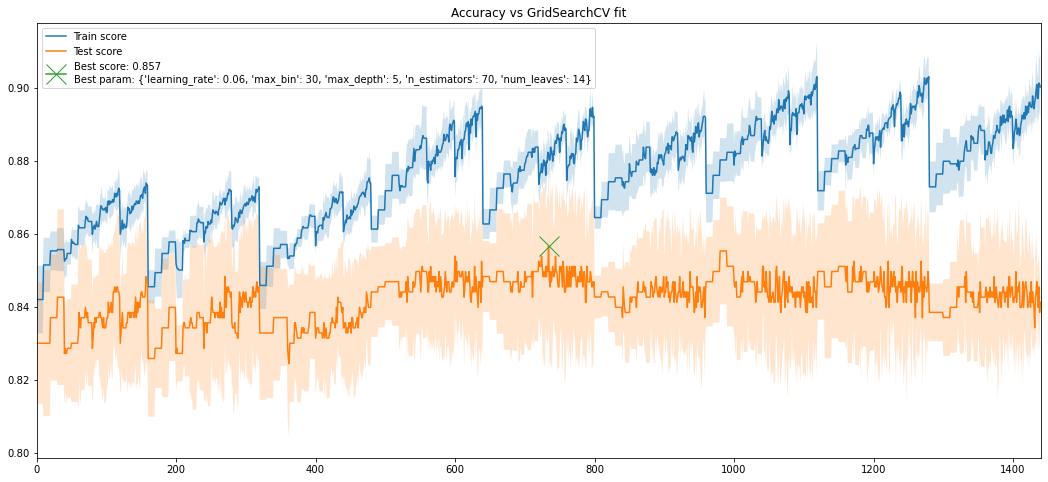

In [270]:
# Boosting model hyperparameter tuning with GridSearchCV
model = LGBMClassifier()
#model = GradientBoostingClassifier()

parameters = {
    'learning_rate': [0.03, 0.06, 0.08],
    'n_estimators': [60, 70, 80, 90],
    'max_bin': [25, 30, 35],
    'num_leaves' :  np.arange(10,20),
    'max_depth' : np.arange(3,7)
}

#scoring = {'AUC': 'roc_auc', 'F1': 'f1'}
#grid_search = GridSearchCV(model, parameters, scoring = scoring, refit='AUC', n_jobs=-1, cv=5, return_train_score=True, verbose=1)

grid_search = GridSearchCV(model, parameters, n_jobs=-1, cv=5, return_train_score=True, verbose=1)
grid_search.fit(model_train_X, model_train_y)

print(grid_search.best_params_)
model_evaluation(grid_search.best_estimator_, model_train_X, model_train_y, model_test_X, model_test_y)
plot_cv(grid_search)

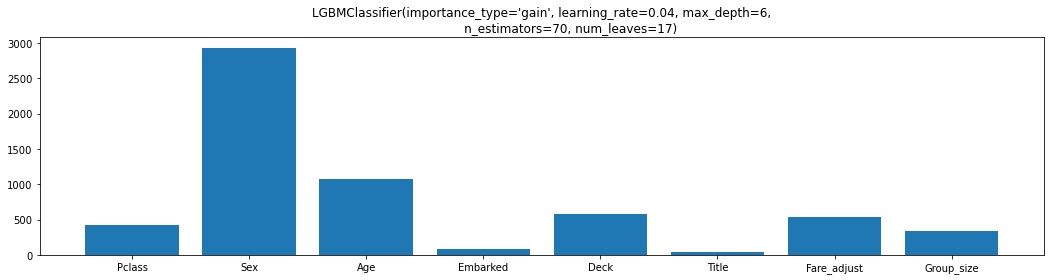

In [208]:
# Plot feature importance
params = {'learning_rate': 0.04, 'max_depth': 6, 'n_estimators': 70, 'num_leaves': 17}
params = {'learning_rate': 0.07, 'max_depth': 6, 'n_estimators': 70, 'num_leaves': 8}
params = {'learning_rate': 0.06, 'max_bin': 30, 'max_depth': 5, 'n_estimators': 70, 'num_leaves': 14}

model = LGBMClassifier(**params, importance_type = 'gain')
model.fit(model_train_X, model_train_y)

top_features = model.feature_importances_[model.feature_importances_>0.01]
top_features_labels = model_train_X.columns.values[model.feature_importances_>0.01]

plt.figure(figsize=(18,4))
plt.bar(range(len(top_features)), top_features, tick_label = top_features_labels)
plt.title(model)
plt.show()

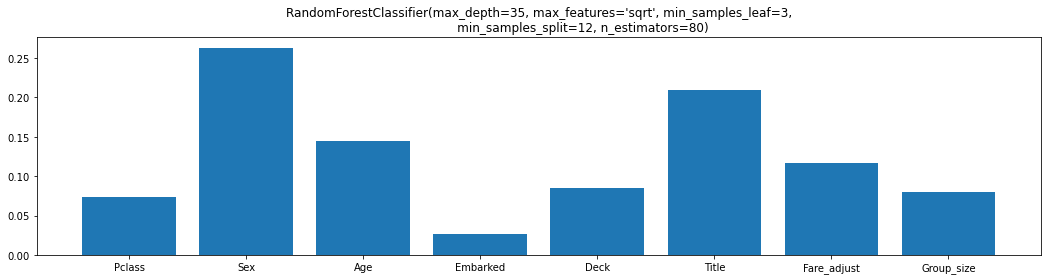

In [205]:
params = {'max_depth': 35, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 12, 'n_estimators': 80}

model = RandomForestClassifier(**params)
model.fit(model_train_X, model_train_y)

top_features = model.feature_importances_[model.feature_importances_>0.01]
top_features_labels = model_train_X.columns.values[model.feature_importances_>0.01]

plt.figure(figsize=(18,4))
plt.bar(range(len(top_features)), top_features, tick_label = top_features_labels)
plt.title(model)
plt.show()

In [209]:
model = Pipeline([('scaller', MinMaxScaler()), ('svc', SVC())])

parameters = {'svc__C': np.linspace(0.1, 10 , 100, dtype = 'int')}

grid_search = GridSearchCV(model, parameters, n_jobs=-1, verbose=0)
grid_search.fit(model_train_X, model_train_y)

print(grid_search.best_score_)
print(grid_search.best_params_)

0.8468728454643948
{'svc__C': 7}


In [269]:
%%time

params = {'learning_rate': 0.06, 'max_bin': 30, 'max_depth': 5, 'n_estimators': 70, 'num_leaves': 14}
model1 = LGBMClassifier(**params)
#model1 = LGBMClassifier(learning_rate=0.02, n_estimators=130) # cat-1 cv=10
#model1 = LGBMClassifier(learning_rate=0.04, n_estimators=70) # cat-1 cv=5
#model1 = LGBMClassifier(learning_rate=0.02, n_estimators=110) # cat1 cat0
#model1 = LGBMClassifier(learning_rate=0.06, n_estimators=40)  # cat2
#model1 = LGBMClassifier(learning_rate=0.04, n_estimators=100) # cat3

model2 = GradientBoostingClassifier()

params = {'max_depth': 35, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 12, 'n_estimators': 80}
model3 = RandomForestClassifier(**params)

model4 = make_pipeline(MinMaxScaler(), SVC(C = 7))

model5 = make_pipeline(MinMaxScaler(), LogisticRegression())

model_voting = VotingClassifier(estimators=[
    ('lgbm', model1),
    ('gbm',  model2),
    ('rf',   model3),    
    ('SVR',  model4),
    ('lr',   model5)],
                                    n_jobs = -1)

model_stacking = StackingClassifier(estimators=[
    ('lgbm', model1),
    ('gbm',  model2),
    ('rf',   model3),
    ('SVR',  model4),
    ('lr',   model5)],
                                    #final_estimator=LogisticRegression(),
                                    n_jobs = -1)

print('-------LGBM-Classifier----------------')
model_evaluation(model1, model_train_X, model_train_y, model_test_X, model_test_y)

print('\n-------GB-Classifier------------------')
model_evaluation(model2, model_train_X, model_train_y, model_test_X, model_test_y)

print('\n-------Random-Forest-Classifier------')
model_evaluation(model3, model_train_X, model_train_y, model_test_X, model_test_y)

print('\n-------SVC---------------------------')
model_evaluation(model4, model_train_X, model_train_y, model_test_X, model_test_y)

print('\n-------Logistic-Regression-----------')
model_evaluation(model5, model_train_X, model_train_y, model_test_X, model_test_y)

print('\n-------Voting-Classifier-------------')
model_evaluation(model_voting, model_train_X, model_train_y, model_test_X, model_test_y)

print('\n-------Stacking-Classifier-----------')
model_evaluation(model_stacking, model_train_X, model_train_y, model_test_X, model_test_y)

-------LGBM-Classifier----------------
CV-score on train: 0.857 with std: 0.022
CV-scores:  [0.867 0.895 0.845 0.838 0.838]
Score on train: 0.878 on test: 0.810
RMSE on train:  0.350 on test: 0.436
MAE on train:   0.122 on test: 0.190

-------GB-Classifier------------------
CV-score on train: 0.831 with std: 0.016
CV-scores:  [0.846 0.832 0.845 0.803 0.831]
Score on train: 0.899 on test: 0.810
RMSE on train:  0.318 on test: 0.436
MAE on train:   0.101 on test: 0.190

-------Random-Forest-Classifier------
CV-score on train: 0.837 with std: 0.017
CV-scores:  [0.839 0.867 0.838 0.817 0.824]
Score on train: 0.878 on test: 0.804
RMSE on train:  0.350 on test: 0.442
MAE on train:   0.122 on test: 0.196

-------SVC---------------------------
CV-score on train: 0.847 with std: 0.023
CV-scores:  [0.832 0.888 0.838 0.824 0.852]
Score on train: 0.855 on test: 0.777
RMSE on train:  0.380 on test: 0.473
MAE on train:   0.145 on test: 0.223

-------Logistic-Regression-----------
CV-score on train: 0

In [257]:
# pick the best estimator
# try with different features 
# hypertune more parameters

model_final = model_stacking

model_final.fit(train_X, train_y)
prediction = model_final.predict(test_X)

prediction_df = test[['PassengerId']].copy()
prediction_df['Survived'] = prediction

prediction_df.to_csv('submission_titanic_stacking.csv',index=False)